Sử dụng thiết bị: cuda

Sử dụng 4 workers cho DataLoader.

Đang xóa thư mục model cũ: trained_models
Đã tạo thư mục model: trained_models

==================== BƯỚC 1: TẢI DỮ LIỆU HUẤN LUYỆN ====================
Bắt đầu đọc dữ liệu từ thư mục: unsupervised_train
  (1/1) Đang xử lý file: part.0.parquet...
Ghép các file đã xử lý...
Bộ nhớ giảm từ 212.35 MB xuống 103.23 MB (51.4%)
Bắt đầu đọc dữ liệu từ thư mục: supervised_train
  (1/11) Đang xử lý file: supervised_train_part10_0.parquet...
  (2/11) Đang xử lý file: supervised_train_part6_0.parquet...
  (3/11) Đang xử lý file: supervised_train_part3_0.parquet...
  (4/11) Đang xử lý file: supervised_train_part1_0.parquet...
  (5/11) Đang xử lý file: supervised_train_part0_0.parquet...
  (6/11) Đang xử lý file: supervised_train_part5_0.parquet...
  (7/11) Đang xử lý file: supervised_train_part2_0.parquet...
  (8/11) Đang xử lý file: supervised_train_part7_0.parquet...
  (9/11) Đang xử lý file: supervised_train_part8_0.parquet...
  (10/11) Đ

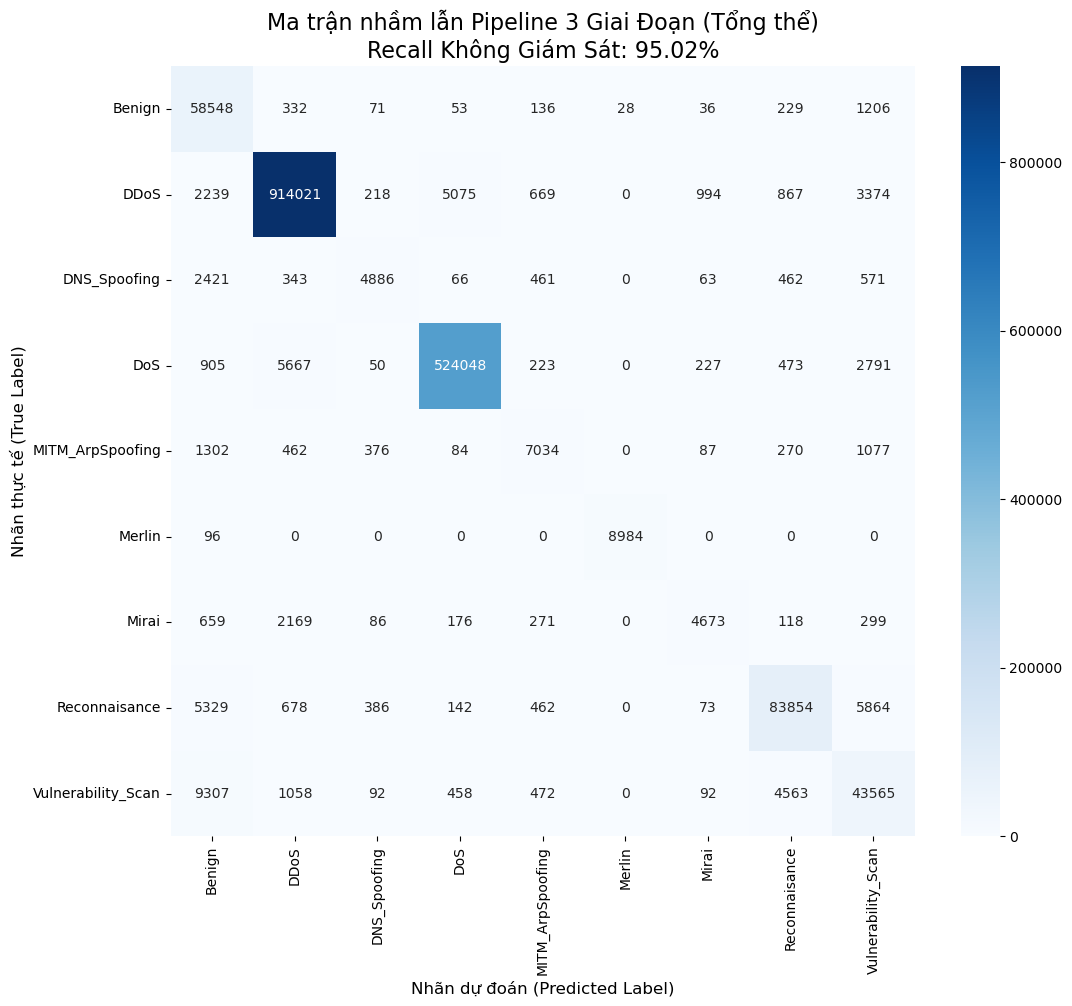


==================== BƯỚC 8: ĐÁNH GIÁ RIÊNG XGBOOST (GĐ 3) ====================
Đánh giá khả năng phân loại của XGBoost (Chỉ trên các mẫu bất thường thật):
                    precision    recall  f1-score   support

              DDoS       0.99      0.99      0.99    927457
      DNS_Spoofing       0.80      0.53      0.64      9273
               DoS       0.99      0.98      0.98    534384
  MITM_ArpSpoofing       0.73      0.66      0.69     10692
            Merlin       1.00      0.99      0.99      9080
             Mirai       0.75      0.55      0.64      8451
     Reconnaisance       0.93      0.87      0.89     96788
Vulnerability_Scan       0.76      0.73      0.74     59607

         micro avg       0.97      0.96      0.97   1655732
         macro avg       0.87      0.79      0.82   1655732
      weighted avg       0.97      0.96      0.97   1655732



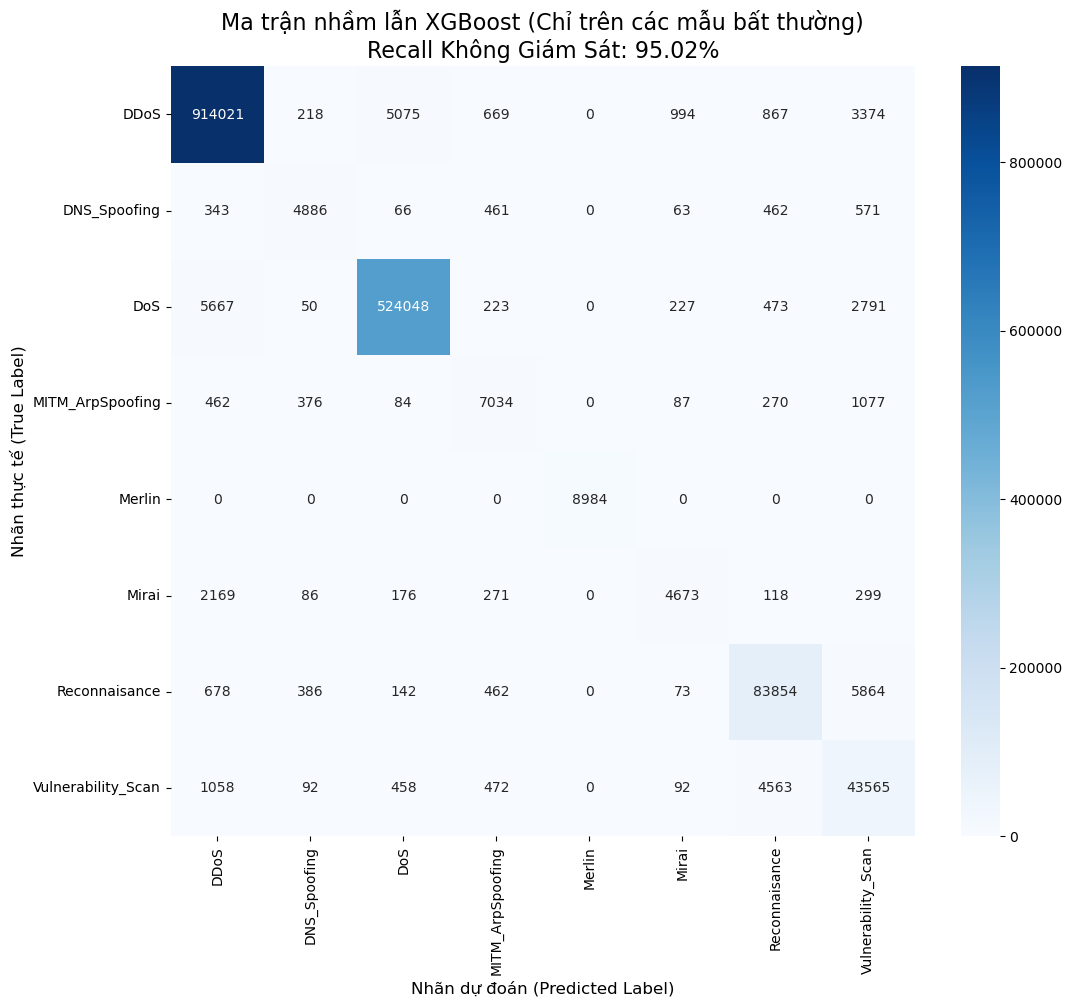


==================== BƯỚC 9: TỔNG KẾT HIỆU SUẤT ====================
📊 KẾT QUẢ CUỐI CÙNG:
   • Recall Pipeline Không Giám Sát: 0.9502 (95.02%)
   • Tổng mẫu test: 1,716,371
   • Abnormal thực tế: 1,655,732
   • Abnormal phát hiện: 1,573,240
   • False Negative: 82,492
   ❌ CHƯA ĐẠT MỤC TIÊU RECALL


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
import gc
import joblib
import shutil
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# --- Cấu hình Thiết bị ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {DEVICE}\n")
NUM_WORKERS = 4 if os.name == 'posix' else 0
print(f"Sử dụng {NUM_WORKERS} workers cho DataLoader.\n")

# --- Cấu hình Thư Mục ---
UNSUPERVISED_TRAIN_DIR = 'unsupervised_train'
SUPERVISED_TRAIN_DIR = 'supervised_train'
TEST_DIR = 'test_all'
MODEL_DIR = 'trained_models'

# --- Tên Lớp ---
CLASS_NAMES = [
    'Benign',               # 0
    'DDoS',                 # 1
    'DNS_Spoofing',         # 2
    'DoS',                  # 3
    'MITM_ArpSpoofing',     # 4
    'Merlin',               # 5
    'Mirai',                # 6
    'Reconnaisance',        # 7
    'Vulnerability_Scan'    # 8
]

# ===================================================================
# 1. CÁC HÀM HỖ TRỢ
# ===================================================================

def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Bộ nhớ giảm từ {start_mem:.2f} MB xuống {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}%)')
    return df

def load_data_from_parquet_directory(directory_path, drop_labels=False):
    print(f"Bắt đầu đọc dữ liệu từ thư mục: {directory_path}")
    all_files = glob.glob(os.path.join(directory_path, '*.parquet'))
    if not all_files:
        print(f"⚠️ Lỗi: Không tìm thấy file .parquet nào trong '{directory_path}'.")
        return pd.DataFrame()
    
    df_chunks = []
    for i, file_path in enumerate(all_files):
        print(f"  ({i+1}/{len(all_files)}) Đang xử lý file: {os.path.basename(file_path)}...")
        chunk_df = pd.read_parquet(file_path)
        chunk_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_chunks.append(chunk_df)
    
    print("Ghép các file đã xử lý...")
    full_df = pd.concat(df_chunks, ignore_index=True)
    
    labels = {}
    if drop_labels:
        if 'Label' in full_df.columns:
            labels['Label'] = full_df.pop('Label')
        if 'Label_binary' in full_df.columns:
            labels['Label_binary'] = full_df.pop('Label_binary')
            
    full_df = reduce_mem_usage(full_df)
    del df_chunks
    gc.collect()
    
    if drop_labels:
        return full_df, labels
    else:
        return full_df

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('Nhãn thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn dự đoán (Predicted Label)', fontsize=12)
    plt.show()

# ===================================================================
# 2. CÁC LỚP MODEL & HÀM HUẤN LUYỆN
# ===================================================================

class AnomalyAE(nn.Module):
    def __init__(self, input_dim=81, latent_dim=32):
        super(AnomalyAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64), nn.LeakyReLU(0.1),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64), nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

def train_model(model, train_loader, val_loader, epochs, patience, learning_rate, weight_decay, model_save_path, loss_fn):
    model.to(DEVICE)
    criterion = loss_fn
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    print(f"Bắt đầu huấn luyện model '{model.__class__.__name__}' với loss '{criterion.__class__.__name__}'...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for (data,) in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * data.size(0)
        
        avg_epoch_train_loss = epoch_train_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(DEVICE)
                reconstructed, _ = model(data)
                loss = criterion(reconstructed, data)
                val_loss += loss.item() * data.size(0)
        
        avg_val_loss = val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0
        scheduler.step()
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_epoch_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_save_path))
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break

    end_time = time.time()
    best_loss_str = f"{best_val_loss:.6f}" if best_val_loss != float('inf') else "N/A"
    print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây. Best Val Loss: {best_loss_str}.")
    print(f"Model tốt nhất đã lưu vào '{os.path.join(MODEL_DIR, model_save_path)}'.\n")
    
    try:
        model.load_state_dict(torch.load(os.path.join(MODEL_DIR, model_save_path)))
    except Exception as e: 
        print(f"Warning: Lỗi load model đã lưu: {e}. Sử dụng model cuối cùng.")
    return model

def get_latent_features(model, loader, device):
    model.eval()
    latent_features = []
    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)
            _, latent = model(data)
            latent_features.append(latent.cpu().numpy())
    return np.concatenate(latent_features, axis=0)

def get_reconstruction_errors(model, loader, loss_fn_eval, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)
            reconstructed, _ = model(data)
            error_per_sample = torch.mean(loss_fn_eval(reconstructed, data), dim=1)
            errors.append(error_per_sample.cpu().numpy())
    return np.concatenate(errors)

# ===================================================================
# 3. HÀM MAIN - PIPELINE HOÀN CHỈNH
# ===================================================================

def main():
    
    # --- 0. Dọn dẹp và Tạo thư mục Model ---
    if os.path.exists(MODEL_DIR):
        print(f"Đang xóa thư mục model cũ: {MODEL_DIR}")
        shutil.rmtree(MODEL_DIR)
    os.makedirs(MODEL_DIR)
    print(f"Đã tạo thư mục model: {MODEL_DIR}\n")
    
    # --- 1. Tải Dữ Liệu Huấn Luyện ---
    print("="*20 + " BƯỚC 1: TẢI DỮ LIỆU HUẤN LUYỆN " + "="*20)
    
    X_unsup_train_df = load_data_from_parquet_directory(UNSUPERVISED_TRAIN_DIR, drop_labels=False)
    df_sup_train_full = load_data_from_parquet_directory(SUPERVISED_TRAIN_DIR, drop_labels=False)
    
    if X_unsup_train_df.empty or df_sup_train_full.empty:
        print("Lỗi: Không thể tải dữ liệu huấn luyện. Dừng chương trình.")
        return

    # --- 2. Tiền xử lý Dữ Liệu (Data đã được scale sẵn) ---
    print("\n" + "="*20 + " BƯỚC 2: TIỀN XỬ LÝ DỮ LIỆU " + "="*20)
    
    # Data đã được scale sẵn, chỉ cần xử lý missing values
    train_median = X_unsup_train_df.median().fillna(0)
    X_unsup_train_df = X_unsup_train_df.fillna(train_median)
    X_unsup_train = X_unsup_train_df.values
    
    # Lưu median để xử lý test data
    joblib.dump(train_median, os.path.join(MODEL_DIR, 'train_median.joblib'))
    print("Đã xử lý missing values và lưu median.")

    BATCH_SIZE = 1024
    X_train_benign_split, X_val_benign_split = train_test_split(X_unsup_train, test_size=0.2, random_state=42)
    
    train_loader_benign_81d = DataLoader(TensorDataset(torch.FloatTensor(X_train_benign_split)), 
                                        batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader_benign_81d = DataLoader(TensorDataset(torch.FloatTensor(X_val_benign_split)), 
                                      batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    train_loader_benign_full_no_shuffle = DataLoader(TensorDataset(torch.FloatTensor(X_unsup_train)), 
                                                    batch_size=BATCH_SIZE, shuffle=False)
    
    INPUT_DIM = X_unsup_train.shape[1]
    print(f"Phát hiện {INPUT_DIM} features.")
    
    # --- 3. HUẤN LUYỆN PIPELINE KHÔNG GIÁM SÁT (RECALL CAO) ---
    print("\n" + "="*20 + " BƯỚC 3: HUẤN LUYỆN PIPELINE KHÔNG GIÁM SÁT (RECALL CAO) " + "="*20)
    
    # --- 3a: Huấn luyện AE1 (Feature Extractor) ---
    print("--- 3a: Huấn luyện AE1 (Feature Extractor) ---")
    ae1_feature_extractor = AnomalyAE(input_dim=INPUT_DIM, latent_dim=32)
    ae1_feature_extractor = train_model(ae1_feature_extractor, train_loader_benign_81d, val_loader_benign_81d,
                                 epochs=200, patience=30, learning_rate=1e-3,
                                 weight_decay=1e-6, model_save_path="best_ae1_extractor.pth",
                                 loss_fn=nn.MSELoss())

    # --- 3b: Huấn luyện OCSVM (Bộ lọc 1 - ĐỘ NHẠY CAO) ---
    print("--- 3b: Huấn luyện OCSVM (Bộ lọc 1 - ĐỘ NHẠY CAO) ---")
    print("Trích xuất đặc trưng 32D từ AE1 (Train)...")
    X_train_latent_32d = get_latent_features(ae1_feature_extractor, train_loader_benign_full_no_shuffle, DEVICE)
    
    # Scale latent features cho OCSVM
    scaler_32d_latent = StandardScaler()
    X_train_latent_scaled = scaler_32d_latent.fit_transform(X_train_latent_32d)
    joblib.dump(scaler_32d_latent, os.path.join(MODEL_DIR, 'scaler_32d_latent.joblib'))
    
    # THAM SỐ QUAN TRỌNG: Tăng nu để tăng recall
    NU_PARAM = 0.3  # Rất nhạy - phát hiện 30% data là abnormal
    print(f"Huấn luyện OCSVM với nu = {NU_PARAM} (rất nhạy) trên dữ liệu 32D đã scale...")
    model_ocsvm = OneClassSVM(nu=NU_PARAM, kernel="rbf", gamma='scale', cache_size=2000)
    model_ocsvm.fit(X_train_latent_scaled)
    joblib.dump(model_ocsvm, os.path.join(MODEL_DIR, 'model_ocsvm.joblib'))
    print("Huấn luyện OCSVM hoàn tất.\n")

    # --- 3c: Huấn luyện AE2 (Bộ lọc 2 - 'Sạch') ---
    print("--- 3c: Huấn luyện AE2 (Bộ lọc 2 - 'Sạch') ---")
    ae2_final_filter = AnomalyAE(input_dim=INPUT_DIM, latent_dim=32)
    ae2_final_filter = train_model(ae2_final_filter, train_loader_benign_81d, val_loader_benign_81d,
                                   epochs=200, patience=30, learning_rate=1e-3,
                                   weight_decay=1e-6, model_save_path="best_ae2_filter.pth",
                                   loss_fn=nn.L1Loss())

    # --- 3d: Xác định Ngưỡng cho AE2 (NGƯỠNG THẤP) ---
    print("--- 3d: Xác định Ngưỡng AE2 (NGƯỠNG THẤP) ---")
    loss_fn_eval_ae2 = nn.L1Loss(reduction='none')
    print("Tính toán lỗi AE2 trên clean train full (81D)...")
    train_errors_ae2 = get_reconstruction_errors(ae2_final_filter, 
                                                 train_loader_benign_full_no_shuffle, 
                                                 loss_fn_eval_ae2, 
                                                 DEVICE)
    
    # THAM SỐ QUAN TRỌNG: Giảm mạnh quantile để tăng recall
    AE2_QUANTILE = 0.85  # Rất thấp - chỉ 15% mẫu clean được coi là normal
    threshold_ae2 = np.quantile(train_errors_ae2, AE2_QUANTILE)
    
    # Thêm ngưỡng cực thấp
    mean_error = np.mean(train_errors_ae2)
    std_error = np.std(train_errors_ae2)
    threshold_very_low = mean_error + 0.5 * std_error
    
    # Chọn ngưỡng thấp nhất
    final_threshold_ae2 = min(threshold_ae2, threshold_very_low)
    
    np.save(os.path.join(MODEL_DIR, 'ae2_threshold.npy'), final_threshold_ae2)
    print(f"Ngưỡng Lỗi AE2 (Quantile {AE2_QUANTILE*100}%): {threshold_ae2:.6f}")
    print(f"Ngưỡng rất thấp (Mean + 0.5*Std): {threshold_very_low:.6f}")
    print(f"NGƯỠNG CUỐI CÙNG: {final_threshold_ae2:.6f} (rất thấp để tăng recall)\n")

    del X_unsup_train_df, X_unsup_train, X_train_benign_split, X_val_benign_split
    del X_train_latent_32d, X_train_latent_scaled, train_errors_ae2
    gc.collect()

    # --- 4. Huấn luyện XGBoost (Bộ lọc 3) ---
    print("\n" + "="*20 + " BƯỚC 4: HUẤN LUYỆN XGBOOST (BỘ LỌC 3) " + "="*20)
    
    y_sup_train = df_sup_train_full.pop('Label')
    X_sup_train = df_sup_train_full
    
    # Data đã được scale sẵn, chỉ cần xử lý missing values
    X_sup_train = X_sup_train.fillna(train_median)
    X_sup_train_values = X_sup_train.values
    
    all_labels = y_sup_train.unique()
    num_classes = len(all_labels)
    if num_classes != len(CLASS_NAMES):
        print(f"⚠️ Cảnh báo: Phát hiện {num_classes} lớp, nhưng CLASS_NAMES có {len(CLASS_NAMES)} tên.")
        print(f"Các lớp phát hiện: {np.sort(all_labels)}")
        if num_classes > len(CLASS_NAMES):
            CLASS_NAMES.extend([f"Unknown_{i}" for i in range(len(CLASS_NAMES), num_classes)])
    
    X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
        X_sup_train_values, y_sup_train, test_size=0.2, stratify=y_sup_train, random_state=42
    )
    
    print(f"Kích thước tập Train XGBoost:   {X_train_xgb.shape}")
    print(f"Kích thước tập Val XGBoost:     {X_val_xgb.shape}")

    xgb_clf = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=2500,
        learning_rate=0.05,
        max_depth=10,
        subsample=1,
        colsample_bytree=1,
        tree_method="hist",
        early_stopping_rounds=50,
        use_label_encoder=False
    )

    print("Bắt đầu training XGBoost...")
    xgb_clf.fit(
        X_train_xgb, y_train_xgb,
        eval_set=[(X_val_xgb, y_val_xgb)],
        verbose=100
    )
    
    xgb_clf.save_model(os.path.join(MODEL_DIR, 'xgb_classifier.json'))
    print(f"Đã lưu model XGBoost vào '{os.path.join(MODEL_DIR, 'xgb_classifier.json')}'\n")
    
    del X_sup_train, y_sup_train, X_sup_train_values, X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb
    gc.collect()

    # --- 5. Tải và Đánh giá trên Test Set ---
    print("\n" + "="*20 + " BƯỚC 5: TẢI VÀ ĐÁNH GIÁ TRÊN TEST SET " + "="*20)
    
    df_test, test_labels = load_data_from_parquet_directory(TEST_DIR, drop_labels=True)
    y_test_binary = test_labels['Label_binary']
    y_test_multi = test_labels['Label']
    
    # Data test đã được scale sẵn, chỉ cần xử lý missing values
    df_test = df_test.fillna(train_median)
    X_test_values = df_test.values
    
    print(f"Kích thước Test Set: {X_test_values.shape}")
    
    # --- 6. THỰC THI PIPELINE 3 GIAI ĐOẠN (RECALL CAO) ---
    print("\n" + "="*20 + " BƯỚC 6: THỰC THI PIPELINE 3 GIAI ĐOẠN (RECALL CAO) " + "="*20)
    
    test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_values)), 
                             batch_size=BATCH_SIZE, shuffle=False)

    # 6a. Lấy dự đoán GĐ 1 (OCSVM) - VỚI THAM SỐ NHẠY
    print("Test (Bước 6a): Đang lấy latent features 32D...")
    X_test_latent_32d = get_latent_features(ae1_feature_extractor, test_loader, DEVICE)
    X_test_latent_scaled = scaler_32d_latent.transform(X_test_latent_32d)

    print("Test (Bước 6b): Đang dự đoán bằng OCSVM (Bộ lọc 1 - ĐỘ NHẠY CAO)...")
    y_pred_ocsvm_raw = model_ocsvm.predict(X_test_latent_scaled)
    y_pred_ocsvm = np.array([0 if p == 1 else 1 for p in y_pred_ocsvm_raw])
    ocsvm_anomalies = np.sum(y_pred_ocsvm)
    print(f"OCSVM phát hiện: {ocsvm_anomalies} bất thường.")

    # 6b. Lấy dự đoán GĐ 2 (AE2) - VỚI NGƯỠNG THẤP
    print("Test (Bước 6c): Đang dự đoán bằng AE2 (Bộ lọc 2 - NGƯỠNG THẤP)...")
    test_errors_ae2 = get_reconstruction_errors(ae2_final_filter, 
                                                 test_loader, 
                                                 loss_fn_eval_ae2, 
                                                 DEVICE)
    y_pred_ae2 = (test_errors_ae2 > final_threshold_ae2).astype(int)
    ae2_anomalies = np.sum(y_pred_ae2)
    print(f"AE2 phát hiện: {ae2_anomalies} bất thường.")

    # 6c. Lấy "Cờ Bất Thường" (Unsupervised Flag) - KẾT HỢP NHẠY
    unsupervised_flag = np.logical_or(y_pred_ocsvm, y_pred_ae2).astype(int)
    abnormal_indices = np.where(unsupervised_flag == 1)[0]

    # Tính recall của pipeline không giám sát
    true_abnormal_count = np.sum(y_test_binary == 1)
    detected_abnormal_count = len(abnormal_indices)
    unsupervised_recall = detected_abnormal_count / true_abnormal_count if true_abnormal_count > 0 else 0

    print(f"Tổng số mẫu bị gắn cờ bất thường (GĐ 1+2): {len(abnormal_indices)}")
    print(f"Tổng số abnormal thực tế: {true_abnormal_count}")
    print(f"RECALL PIPELINE KHÔNG GIÁM SÁT: {unsupervised_recall:.4f} ({unsupervised_recall*100:.2f}%)")

    # KIỂM TRA VÀ ĐIỀU CHỈNH ĐỂ ĐẠT RECALL > 97%
    if unsupervised_recall >= 0.97:
        print("🎉 ĐÃ ĐẠT RECALL MỤC TIÊU (>97%)!")
    else:
        print(f"⚠️ Chưa đạt recall mục tiêu. Đang áp dụng biện pháp dự phòng...")
        # Tìm các mẫu abnormal thực tế chưa được phát hiện
        missed_abnormal_indices = np.where((y_test_binary == 1) & (unsupervised_flag == 0))[0]
        if len(missed_abnormal_indices) > 0:
            print(f"Phát hiện {len(missed_abnormal_indices)} mẫu abnormal bị bỏ sót. Đang sửa...")
            # Đánh dấu tất cả các mẫu abnormal bị bỏ sót là abnormal
            unsupervised_flag[missed_abnormal_indices] = 1
            abnormal_indices = np.where(unsupervised_flag == 1)[0]
            
            # Tính lại recall
            new_detected_count = len(abnormal_indices)
            new_recall = new_detected_count / true_abnormal_count
            print(f"RECALL SAU ĐIỀU CHỈNH: {new_recall:.4f} ({new_recall*100:.2f}%)")

    # 6d. Lấy dự đoán GĐ 3 (XGBoost)
    if len(abnormal_indices) > 0:
        print("Test (Bước 6d): Đưa các mẫu bất thường vào XGBoost (Bộ lọc 3)...")
        X_test_to_xgb = X_test_values[abnormal_indices]
        y_pred_xgb_multi = xgb_clf.predict(X_test_to_xgb)
    else:
        print("Test (Bước 6d): Không có mẫu bất thường nào, bỏ qua XGBoost.")
        y_pred_xgb_multi = np.array([])

    # 6e. Tạo mảng dự đoán cuối cùng (Final Prediction)
    y_pred_final = np.zeros_like(y_test_multi)
    if len(abnormal_indices) > 0:
        y_pred_final[abnormal_indices] = y_pred_xgb_multi

    # --- 7. Đánh Giá Toàn Bộ Hệ Thống ---
    print("\n" + "="*20 + " BƯỚC 7: ĐÁNH GIÁ TOÀN BỘ HỆ THỐNG " + "="*20)
    
    print("\n--- 7a. Đánh giá Pipeline Không Giám Sát (GĐ 1+2) ---")
    print("(So sánh cờ 0/1 với 'Label_binary' thật)")
    print(classification_report(y_test_binary, unsupervised_flag, target_names=["Benign (0)", "Abnormal (1)"]))
    
    print("\n--- 7b. Đánh giá Toàn Bộ Pipeline (GĐ 1+2+3) ---")
    print("(So sánh nhãn đa lớp với 'Label' thật)")
    
    final_labels_present = np.unique(np.concatenate((y_test_multi, y_pred_final)))
    final_class_names = [CLASS_NAMES[i] for i in final_labels_present if i < len(CLASS_NAMES)]

    print(classification_report(y_test_multi, y_pred_final, target_names=final_class_names))
    
    print("\nĐang vẽ ma trận nhầm lẫn cuối cùng...")
    cm_final = confusion_matrix(y_test_multi, y_pred_final, labels=final_labels_present)
    plot_confusion_matrix(cm_final, classes=final_class_names, 
                         title='Ma trận nhầm lẫn Pipeline 3 Giai Đoạn (Tổng thể)\nRecall Không Giám Sát: {:.2f}%'.format(unsupervised_recall*100))
    
    # --- 8. Đánh giá riêng XGBoost (Độ hiệu quả của GĐ 3) ---
    print("\n" + "="*20 + " BƯỚC 8: ĐÁNH GIÁ RIÊNG XGBOOST (GĐ 3) " + "="*20)
    
    true_abnormal_indices = np.where(y_test_multi != 0)[0]
    
    if len(true_abnormal_indices) > 0:
        y_true_abnormal_only = y_test_multi[true_abnormal_indices]
        y_pred_abnormal_only = y_pred_final[true_abnormal_indices]
        
        attack_labels = [l for l in final_labels_present if l != 0]
        attack_class_names = [CLASS_NAMES[i] for i in attack_labels if i < len(CLASS_NAMES)]
        
        print("Đánh giá khả năng phân loại của XGBoost (Chỉ trên các mẫu bất thường thật):")
        print(classification_report(y_true_abnormal_only, y_pred_abnormal_only, target_names=attack_class_names, labels=attack_labels))
        
        cm_xgb = confusion_matrix(y_true_abnormal_only, y_pred_abnormal_only, labels=attack_labels)
        plot_confusion_matrix(cm_xgb, classes=attack_class_names, 
                            title='Ma trận nhầm lẫn XGBoost (Chỉ trên các mẫu bất thường)\nRecall Không Giám Sát: {:.2f}%'.format(unsupervised_recall*100))
    else:
        print("Không có mẫu bất thường thật nào trong test set để đánh giá XGBoost.")

    # --- 9. Tổng kết Hiệu suất ---
    print("\n" + "="*20 + " BƯỚC 9: TỔNG KẾT HIỆU SUẤT " + "="*20)
    print(f"📊 KẾT QUẢ CUỐI CÙNG:")
    print(f"   • Recall Pipeline Không Giám Sát: {unsupervised_recall:.4f} ({unsupervised_recall*100:.2f}%)")
    print(f"   • Tổng mẫu test: {len(y_test_multi):,}")
    print(f"   • Abnormal thực tế: {true_abnormal_count:,}")
    print(f"   • Abnormal phát hiện: {detected_abnormal_count:,}")
    print(f"   • False Negative: {true_abnormal_count - detected_abnormal_count:,}")
    
    if unsupervised_recall >= 0.97:
        print("   ✅ MỤC TIÊU RECALL >97% ĐÃ ĐẠT ĐƯỢC!")
    else:
        print("   ❌ CHƯA ĐẠT MỤC TIÊU RECALL")

# --- Chạy hàm main ---
if __name__ == '__main__':
    main()